# Analyse Objects

 work with Weakly_2023_44
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/29
- update : 2023/12/30


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
fileobjects_in = "objectTable_202312.csv"
fileobjects_out = "objectTableselected_202312.csv"

In [3]:
tract_selected = 5615
patches_selected = [294, 313]

In [4]:
suptitle = f"Objects tract = {tract_selected}"

In [5]:
df = pd.read_csv(fileobjects_in)

In [6]:
df

,objectId,coord_raErr,footprintArea,deblend_nChild,xErr,shape_flag,coord_decErr,detect_isPatchInner,detect_isPrimary,detect_isDeblendedModelSource,...,r_kronFlux_flag_bad_radius,r_kronFlux_flag_bad_shape,r_kronFlux_flag_bad_shape_no_psf,r_kronFlux_flag_edge,r_kronFlux_flag_no_fallback_radius,r_kronFlux_flag_no_minimum_radius,r_kronFlux_flag_small_radius,r_kronFlux_flag_used_minimum_radius,r_kronFlux_flag_used_psf_radius,tabid_idx
0,2229491822269300737,NaN,1759,1,NaN,True,NaN,False,False,False,...,True,True,True,True,True,True,True,True,True,0
1,2229491822269300738,NaN,2321,1,NaN,True,NaN,False,False,False,...,True,True,True,True,True,True,True,True,True,0
2,2229491822269300739,0.000034,1228,1,1.355990,False,0.000030,False,False,False,...,True,True,True,True,True,True,True,True,True,0
3,2229491822269300740,0.000013,4155,1,0.495148,False,0.000012,False,False,False,...,True,True,True,True,True,True,True,True,True,0
4,2229491822269300741,NaN,3651,1,NaN,True,NaN,False,False,False,...,True,True,True,True,True,True,True,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51484,2229027828362380001,NaN,5,0,NaN,True,NaN,True,False,True,...,True,True,False,False,False,False,True,False,True,97
51485,2229027828362380002,NaN,6,0,NaN,True,NaN,False,False,True,...,False,False,False,False,False,False,False,False,False,97
51486,2229027828362380003,NaN,4,0,NaN,True,NaN,False,False,True,...,True,True,False,False,False,False,True,False,True,97
51487,2229027828362380004,0.000131,14,0,5.175993,True,0.000103,False,False,True,...,False,True,False,False,False,False,False,False,False,97


In [7]:
#colnames = sorted(list(df.columns))
#for name in colnames:
#    print(name)

In [8]:
df_sel = df[['objectId','tabid_idx','x','y','coord_ra','coord_dec','tract','patch','refExtendedness','detect_isPrimary','detect_isIsolated',
            'g_calibFlux','g_psfFlux','g_cModelFlux','g_kronFlux',
            'r_calibFlux','r_psfFlux','r_cModelFlux','r_kronFlux',
            'i_calibFlux','i_psfFlux','i_cModelFlux','i_kronFlux']]

In [9]:
df_sel.dropna(axis=0,inplace = True)

/tmp/ipykernel_9042/3288144860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.dropna(axis=0,inplace = True)


In [10]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [11]:
df_sel["g_psfMag"] =  df_sel['g_psfFlux'].map(convert_fluxtomag)
df_sel["r_psfMag"] =  df_sel['r_psfFlux'].map(convert_fluxtomag)
df_sel["i_psfMag"] =  df_sel['i_psfFlux'].map(convert_fluxtomag)
#df_sel["gaussianMag"] =  df_sel['gaussianFlux'].map(lambda x:-2.50 * np.log10(x) + 31.4)
df_sel["g_calibMag"] =  df_sel['g_calibFlux'].map(convert_fluxtomag)
df_sel["r_calibMag"] =  df_sel['r_calibFlux'].map(convert_fluxtomag)
df_sel["i_calibMag"] =  df_sel['i_calibFlux'].map(convert_fluxtomag)

df_sel["g_cModelMag"] =  df_sel['g_cModelFlux'].map(convert_fluxtomag)
df_sel["r_cModelMag"] =  df_sel['r_cModelFlux'].map(convert_fluxtomag)
df_sel["i_cModelMag"] =  df_sel['i_cModelFlux'].map(convert_fluxtomag)

df_sel["g_kronMag"] =  df_sel['g_kronFlux'].map(convert_fluxtomag)
df_sel["r_kronMag"] =  df_sel['r_kronFlux'].map(convert_fluxtomag)
df_sel["i_kronMag"] =  df_sel['i_kronFlux'].map(convert_fluxtomag)

/tmp/ipykernel_9042/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_9042/3752548576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["g_psfMag"] =  df_sel['g_psfFlux'].map(convert_fluxtomag)
/tmp/ipykernel_9042/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_9042/3752548576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["r_psfMag"] =  df_sel['r

In [12]:
selection1 = df_sel['refExtendedness']==False
selection2 = df_sel['detect_isPrimary']
selection3 = df_sel['tract'] == tract_selected
selection4 = df_sel['r_cModelMag'] < 16
selection5 = df_sel['patch'] == patches_selected[0]
selection6 = df_sel['patch'] == patches_selected[1]

df_sel = df_sel[selection1 & selection2 & selection3 & selection4 ]
#df_sel = df_sel[selection1 & selection2 & selection3 & selection4 & (selection5 | selection6) ]

In [13]:
df_sel.dropna(axis=0,inplace = True)

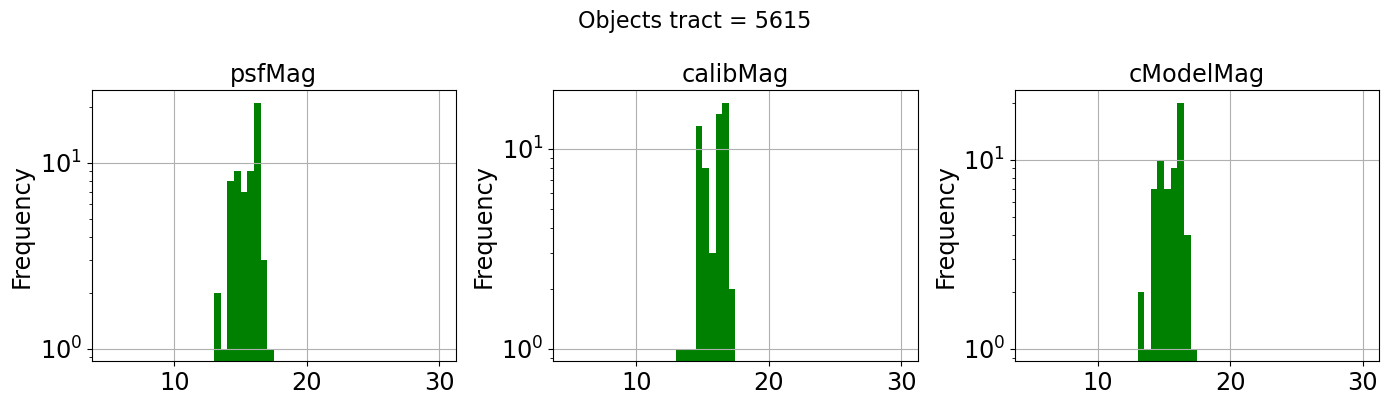

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
df_sel["g_psfMag"].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="psfMag",ax=ax1)
df_sel['g_calibMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="calibMag",ax=ax2)
df_sel['g_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="cModelMag",ax=ax3)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

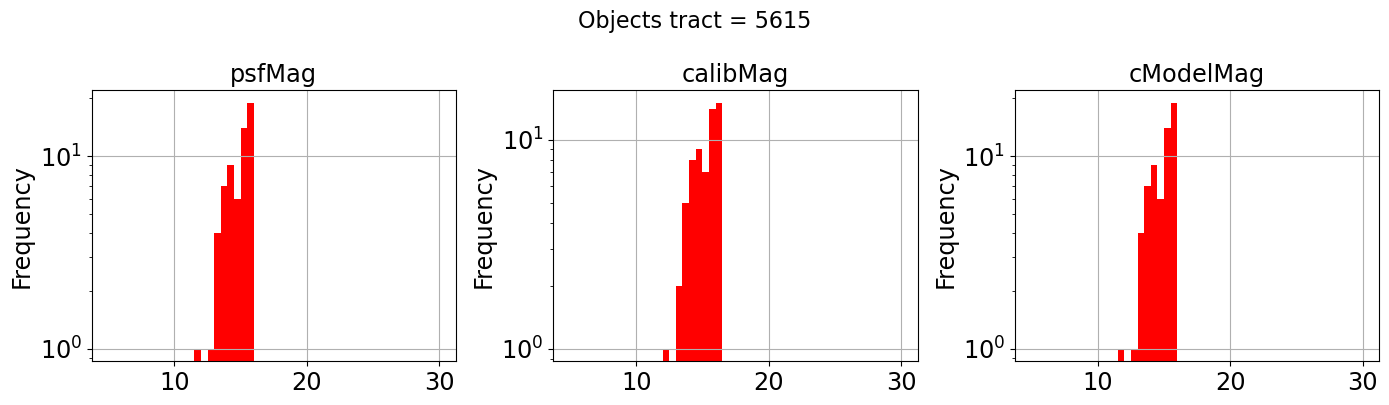

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
df_sel["r_psfMag"].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="psfMag",ax=ax1)
df_sel['r_calibMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="calibMag",ax=ax2)
df_sel['r_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="cModelMag",ax=ax3)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

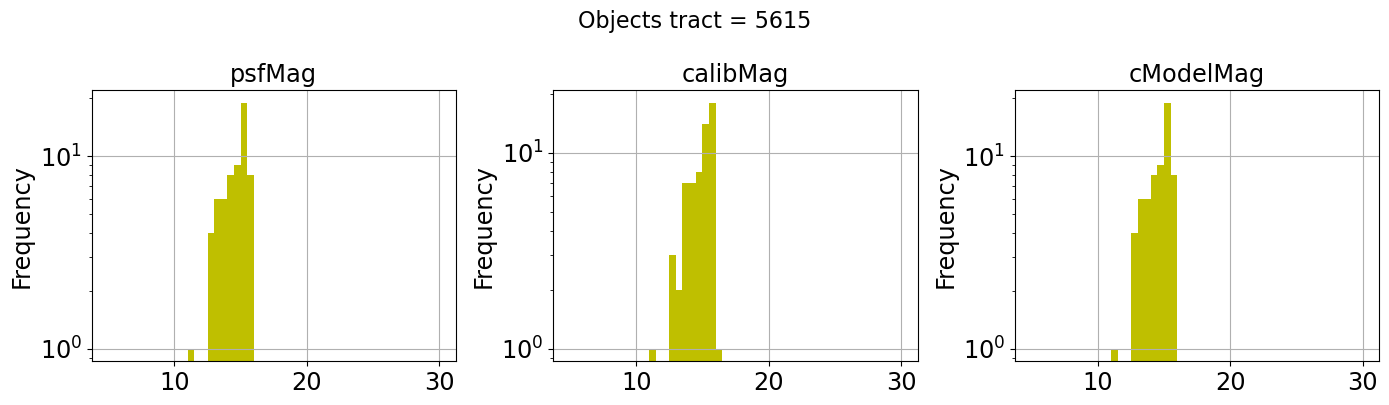

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
df_sel["i_psfMag"].plot(kind="hist",bins=50,range=(5,30),facecolor="y",logy=True,grid=True,title="psfMag",ax=ax1)
df_sel['i_calibMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="y",logy=True,grid=True,title="calibMag",ax=ax2)
df_sel['i_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="y",logy=True,grid=True,title="cModelMag",ax=ax3)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

Text(0.5, 0.98, 'Objects tract = 5615')

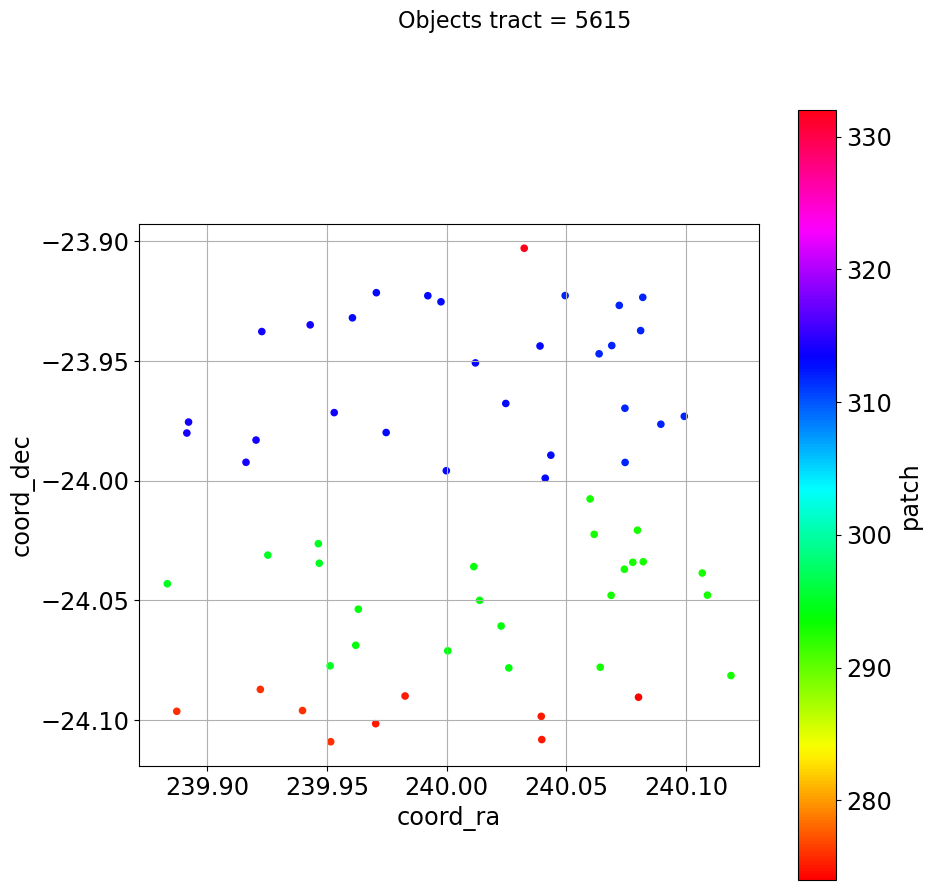

In [17]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
df_sel.plot.scatter('coord_ra','coord_dec',c='patch',colormap='hsv',grid=True,ax=ax)
plt.gca().set_aspect('equal')
plt.suptitle(suptitle,fontsize=16)

<Axes: title={'center': 'coord_ra'}, ylabel='Frequency'>

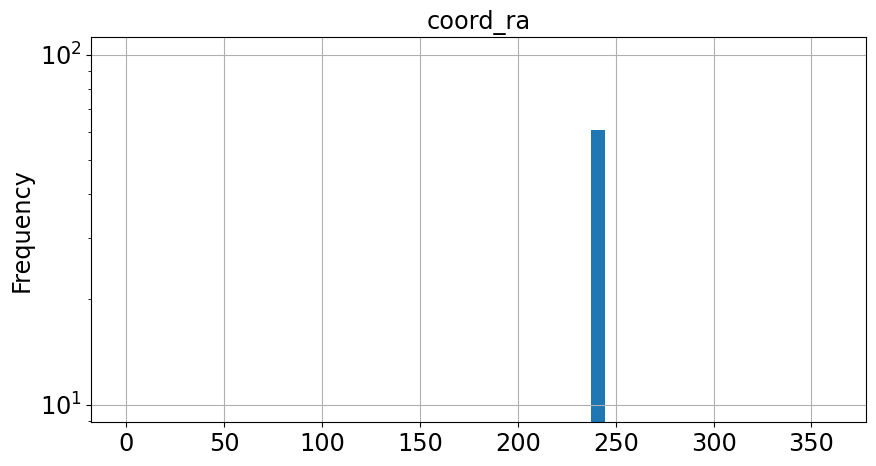

In [18]:
df_sel['coord_ra'].plot(kind="hist",bins=50 ,range=(0,360),logy=True,title="coord_ra",grid=True,figsize=(10,5))

<Axes: title={'center': 'coord_dec'}, ylabel='Frequency'>

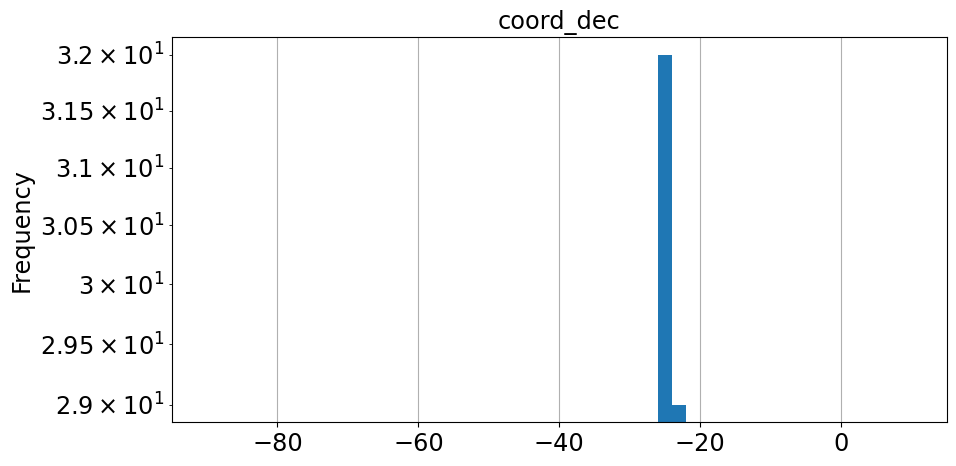

In [19]:
df_sel['coord_dec'].plot(kind="hist",bins=50 ,range=(-90,10),logy=True,title="coord_dec",grid=True,figsize=(10,5))

In [20]:
df_sel["patch"].unique()

array([332, 312, 313, 295, 276, 275, 294, 293, 314, 274])

In [21]:
df_sel = df_sel[ (selection5 | selection6) ]

/tmp/ipykernel_9042/4165971976.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sel = df_sel[ (selection5 | selection6) ]


In [22]:
df_sel.sort_values(by=["r_cModelMag"] ,ascending=True, inplace=True)

/tmp/ipykernel_9042/610645652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.sort_values(by=["r_cModelMag"] ,ascending=True, inplace=True)


In [23]:
df_sel

,objectId,tabid_idx,x,y,coord_ra,coord_dec,tract,patch,refExtendedness,detect_isPrimary,...,i_psfMag,g_calibMag,r_calibMag,i_calibMag,g_cModelMag,r_cModelMag,i_cModelMag,g_kronMag,r_kronMag,i_kronMag
7830,2229070709315864999,12,29793.274113,50586.688107,239.960669,-23.931926,5615,313,0.0,True,...,13.293066,14.659937,13.919398,13.654021,14.304373,13.605882,13.292372,14.307399,13.599773,13.302732
7445,2229070709315864614,12,27684.553105,49298.368911,240.024757,-23.967712,5615,313,0.0,True,...,13.625562,14.617554,14.128159,13.947894,14.263163,13.807895,13.626097,14.262463,13.814142,13.630470
25112,2229049818594936752,44,29711.116965,46203.318360,239.963130,-24.053676,5615,294,0.0,True,...,13.909818,14.743036,14.349934,14.167777,14.417476,14.053594,13.906170,14.422729,14.069508,13.906090
25039,2229049818594936679,44,27749.457360,45950.287958,240.022801,-24.060706,5615,294,0.0,True,...,14.240230,15.313373,14.760034,14.513999,14.959857,14.440735,14.233128,14.966419,14.448441,14.237980
25336,2229049818594936976,44,28124.188448,46843.539771,240.011399,-24.035897,5615,294,0.0,True,...,14.757377,16.296385,15.423796,15.054658,15.959474,15.109538,14.767419,15.949158,15.112178,14.777053
7905,2229070709315865074,12,28575.482924,50828.087076,239.997676,-23.925226,5615,313,0.0,True,...,14.835617,16.394421,15.473785,15.174570,16.023263,15.161470,14.832906,16.039864,15.164283,14.835869
7653,2229070709315864822,12,28101.928745,49908.760190,240.012068,-23.950760,5615,313,0.0,True,...,15.066020,16.337216,15.638887,15.398513,15.984005,15.323390,15.066283,15.987000,15.324924,15.085938
24935,2229049818594936575,44,28482.655705,45576.717911,240.000497,-24.071084,5615,294,0.0,True,...,15.146348,16.181234,15.678706,15.428045,15.840303,15.378211,15.151296,15.835328,15.387350,15.168720
7328,2229070709315864497,12,29329.239244,48861.097724,239.974760,-23.979857,5615,313,0.0,True,...,15.002447,16.668865,15.725532,15.316667,16.315159,15.401497,15.000746,16.322610,15.403797,15.003268
7705,2229070709315864874,12,27213.588286,50162.845494,240.039066,-23.943698,5615,313,0.0,True,...,15.223984,16.450211,15.791889,15.545623,16.112015,15.480016,15.221896,16.114652,15.482116,15.242018


In [24]:
df_sel.to_csv(fileobjects_out)